In [1]:
import random
import time
import collections
class HardModeModel:
    def __init__(self, possible_words, starting_word, final_answer, word_frequencies, all_words):
        self.current_guess = starting_word
        self.final_answer = final_answer
        self.gray_letters = []
        self.all_guesses = possible_words
        self.possible_guesses = possible_words
        self.freq_scoring = {'q': 26, 'j': 25, 'z': 24, 'x': 23, 'v': 22, 'w': 21, 'f': 20, 'k': 19, 'b': 18, 'g': 17, 'm': 16, 'h': 15, 'y': 14, 'p': 13, 'u': 12, 'c': 11, 'n': 10, 'd': 9, 'l': 8, 'i': 7, 't': 6, 'o': 5, 'r': 4, 'a': 3, 's': 2, 'e': 1}
        self.word_freqs = word_frequencies
        
    # This function determines if a guess is valid given the feedback that's been given from guesses 
    # till this point yellow letters is a list of all letters of the guess that are correct but in the wrong 
    # position green letters is a tuple list of all leters of the guess that are in the correct position and 
    # spot with the letters respective position in the tuple list, example green_letters = [('h',2), ('e',3)]
    def _valid_guess(self, guess, green_letters, yellow_letters, gray_letters):
        for letter_tuple in yellow_letters:
            if letter_tuple[0] not in guess or guess[letter_tuple[1]] == letter_tuple[0]:
                return False
        for letter_tuple in green_letters:
            if guess[letter_tuple[1]] != letter_tuple[0]:
                return False
        for letter in gray_letters:
            if letter in guess:
                return False
        return True
    
    # This function provides feedback for a guess given some answer, the notation of the feedback is seen below
    # For a given word heart, the notation used throughout the model is as follows
    # Each letter is given a score of 0, 1, or 2. 0 means that the letter does not exist in the correct answer. 
    # 1 means the letter is yellow, correct letter wrong spot. 2 menas the lettter is green, correct letter and correct
    # spot. if the answer is harsh and our guess is heart, then the resulting notation would be:
    # [('h',2),('e',0),('a',1),('r',0), ('t',0)]
    def _score_guess(self, answer, guess):
        guess_feedback = []
        for i in range(5):
            if guess[i] == answer[i]:
                guess_feedback.append((guess[i],2))
            elif guess[i] in answer:
                guess_feedback.append((guess[i],1))
            else:
                guess_feedback.append((guess[i],0))
        return guess_feedback
    # This function creates a frequency scoring 
    def _score_frequency(self, word):
        score = 0
        for letter in word:
            score += self.freq_scoring[letter]
        return score
    # This function takes feedback in the above form and converts it into a list of green, yellow, and 
    # gray letters green letters and yellow letters are stored in tuples of the letter and their index within 
    # the word gray letters are simply a list of all gray letters
    def _get_green_yellow_gray_letters(self, guess_feedback):
        green_letters = []
        yellow_letters = []
        gray_letters = []
        for index, feedback_tuple in enumerate(guess_feedback):
            if feedback_tuple[1] == 2:
                green_letters.append((feedback_tuple[0], index))
            elif feedback_tuple[1] == 1:
                yellow_letters.append((feedback_tuple[0], index))
            else:
                gray_letters.append(feedback_tuple[0])
        return green_letters, yellow_letters, gray_letters
    def _word_freq_score(self, word):
        score = 1/self.word_freqs[word]
        return score
    
    # This is the main wordle prediction algorithm. It takes in the final_answer we are trying to find, 
    # a current working list of possible guesses, a list of gray letters, and the current guess we have just made
    # It then finds the next guess using a greedy min-max approach 
    def next_guess(self):
        
        # Getting feedback on our current guess based on the answer we're working towards 
        guess_feedback = self._score_guess(self.final_answer, self.current_guess)
        green_letters, yellow_letters, current_gray_letters = self._get_green_yellow_gray_letters(guess_feedback)
        new_gray_letters = self.gray_letters + current_gray_letters
        new_possible_guesses = []
        
        # Based on the feedback of the guess, narrowing down our list of possible guesses we can chose from
        for guess in self.possible_guesses:
            if self._valid_guess(guess, green_letters, yellow_letters, new_gray_letters):
                new_possible_guesses.append(guess)
        self.possible_guesses = new_possible_guesses

        # Creating the guess answer matrix. This matrix is a matrix of all the possible words by all the possible words.
        # The rows represent the possible guesses and the columns represent the possible answers
        # The value at (guess, answer) represents the number of new possible guesses that exist if we guessed 'guess'
        # and the final answer we were working towards was 'answer'.
        guess_answer_matrix = {}
        for guess in self.possible_guesses:
            guess_answer_matrix[guess] = {}
            for answer in self.possible_guesses:
                guess_feedback = self._score_guess(answer,guess)
                curr_green_letters, curr_yellow_letters, curr_gray_letters = self._get_green_yellow_gray_letters(guess_feedback)
                valid_guesses = 0
                new_possible_guesses = self.possible_guesses.copy()
                new_possible_guesses.remove(guess)
                for option in new_possible_guesses:
                    if self._valid_guess(option,curr_green_letters,curr_yellow_letters, curr_gray_letters):
                        valid_guesses += 1
                guess_answer_matrix[guess][answer] = valid_guesses
        
        # Given this matrix of possible guesses for each guess, answer pair, we find the guess that minimizes the 
        # maximum new possible guesses across all possible answers. This is a greedy minmax approach
        max_guess_dict = {}
        for guess in guess_answer_matrix:
            max_possible_guesses = max(guess_answer_matrix[guess].values())
            max_guess_dict.setdefault(max_possible_guesses,[]).append(guess)
        
        first_val = max_guess_dict[list(max_guess_dict.keys())[0]]
        if len(max_guess_dict) == 1 and len(first_val) > 2:
            
            first_test_word = first_val[0]
            second_test_word = first_val[1]
            difference_index = 0
            for i in range(5):
                if first_test_word[i] != second_test_word[i]:
                    difference_index = i
            possible_letters = []
            for word in first_val:
                possible_letters.append(word[difference_index])
            max_letters = 0
            min_guess = ''
            for word in self.all_guesses:
                count = 0
                for letter in possible_letters:
                    if letter in word:
                        count += 1
                if count > max_letters:
                    min_guess = word
                    max_letters = count
            self.current_guess = min_guess

#             min_guess_score = 3000
#             min_guess = ''
#             for key in max_guess_dict:
# #                 for guess in max_guess_dict[key]:
# #                     guess_score = self._score_frequency(guess)
# #                     if guess_score < min_guess_score:
# #                         min_guess_score = guess_score
# #                         min_guess = guess
                
#                 for guess in max_guess_dict[key]:
#                         guess_score = self._word_freq_score(guess)
#                         if guess_score < min_guess_score:
#                             min_guess_score = guess_score
#                             min_guess = guess
            self.current_guess = min_guess
            

        else: 
            self.current_guess = max_guess_dict[min(max_guess_dict.keys())][0]
        
                
        return self.current_guess


In [2]:
#Testing framework 

# Initializing list of all possible wordle guesses
possible_words = []
with open('wordle_solutions.txt') as file:
    for line in file:
        possible_words.append(line.replace('\n',''))
        
all_words = []
with open('common.txt') as file:
    for line in file:
        all_words.append(line.replace('\n',''))
        
word_freqs = {}
with open('word_frequency.txt') as file:
    for line in file:
        text = line.replace('\n','')
        freqs = text.split(' ')[0].split('\t')
        word_freqs[freqs[0]] = int(freqs[1])
        
times = []
counts = []
for word in possible_words[0:500]:
    start = time.time()
    guess = 'crane'
    final_answer = word
    model = HardModeModel(possible_words, guess, final_answer, word_freqs, all_words)
    count = 1
    guesses = [guess]
    while guess != final_answer:
        guess = model.next_guess()
        guesses.append(guess)
        count += 1
    counts.append(count)
    end = time.time()
    final_time= end - start
    times.append(final_time)
    print('Final Answer: ' + str(final_answer) + ', Count: ' + str(count) + ', Guesses: ' + str(guesses) + ', Time: ' + str(final_time) + ' seconds')
print('Average guesses per game: ' + str(sum(counts)/len(counts)))
print('Average time per game: ' + str(sum(times)/len(times)))


# guess = 'rates'
# model = HardModeModel(possible_words, guess, 'moist', word_freqs, all_words) 
# guesses = ['rates']
# while guess != 'moist':
#     guess = model.next_guess()
#     guesses.append(guess)
# print(guesses)

Final Answer: rebus, Count: 4, Guesses: ['crane', 'retro', 'reply', 'rebus'], Time: 0.6069240570068359 seconds
Final Answer: boost, Count: 4, Guesses: ['crane', 'lousy', 'moist', 'boost'], Time: 4.1276209354400635 seconds
Final Answer: truss, Count: 4, Guesses: ['crane', 'drift', 'pushy', 'truss'], Time: 0.04492592811584473 seconds
Final Answer: siege, Count: 3, Guesses: ['crane', 'slide', 'siege'], Time: 0.3354518413543701 seconds
Final Answer: tiger, Count: 3, Guesses: ['crane', 'retro', 'tiger'], Time: 0.5968790054321289 seconds
Final Answer: banal, Count: 3, Guesses: ['crane', 'manly', 'banal'], Time: 0.042145729064941406 seconds
Final Answer: slump, Count: 4, Guesses: ['crane', 'lousy', 'skulk', 'slump'], Time: 4.195923089981079 seconds
Final Answer: crank, Count: 2, Guesses: ['crane', 'crank'], Time: 0.0005562305450439453 seconds
Final Answer: gorge, Count: 4, Guesses: ['crane', 'surge', 'merge', 'gorge'], Time: 0.020235061645507812 seconds
Final Answer: query, Count: 3, Guesses:

Final Answer: movie, Count: 4, Guesses: ['crane', 'slide', 'pique', 'movie'], Time: 0.3324410915374756 seconds
Final Answer: lynch, Count: 3, Guesses: ['crane', 'lunch', 'lynch'], Time: 0.0031280517578125 seconds
Final Answer: saute, Count: 4, Guesses: ['crane', 'table', 'waste', 'saute'], Time: 0.045606136322021484 seconds
Final Answer: allow, Count: 4, Guesses: ['crane', 'aptly', 'aloud', 'allow'], Time: 0.6591968536376953 seconds
Final Answer: renew, Count: 3, Guesses: ['crane', 'inter', 'renew'], Time: 0.008141040802001953 seconds
Final Answer: their, Count: 4, Guesses: ['crane', 'retro', 'tiger', 'their'], Time: 0.5979602336883545 seconds
Final Answer: slosh, Count: 3, Guesses: ['crane', 'lousy', 'slosh'], Time: 4.156029224395752 seconds
Final Answer: purge, Count: 3, Guesses: ['crane', 'surge', 'purge'], Time: 0.020595073699951172 seconds
Final Answer: chest, Count: 2, Guesses: ['crane', 'chest'], Time: 0.0012159347534179688 seconds
Final Answer: depot, Count: 2, Guesses: ['crane

Final Answer: bayou, Count: 3, Guesses: ['crane', 'aptly', 'bayou'], Time: 0.7233448028564453 seconds
Final Answer: atoll, Count: 3, Guesses: ['crane', 'aptly', 'atoll'], Time: 0.7041168212890625 seconds
Final Answer: manor, Count: 3, Guesses: ['crane', 'rayon', 'manor'], Time: 0.0012369155883789062 seconds
Final Answer: creak, Count: 2, Guesses: ['crane', 'creak'], Time: 0.0005362033843994141 seconds
Final Answer: showy, Count: 3, Guesses: ['crane', 'lousy', 'showy'], Time: 4.272967338562012 seconds
Final Answer: phase, Count: 3, Guesses: ['crane', 'slate', 'phase'], Time: 0.028879165649414062 seconds
Final Answer: froth, Count: 3, Guesses: ['crane', 'drift', 'froth'], Time: 0.044467926025390625 seconds
Final Answer: depth, Count: 3, Guesses: ['crane', 'depot', 'depth'], Time: 0.531804084777832 seconds
Final Answer: gloom, Count: 4, Guesses: ['crane', 'lousy', 'bloom', 'gloom'], Time: 4.1219072341918945 seconds
Final Answer: flood, Count: 4, Guesses: ['crane', 'lousy', 'bloom', 'flood

Final Answer: patty, Count: 3, Guesses: ['crane', 'aptly', 'patty'], Time: 0.7081129550933838 seconds
Final Answer: cling, Count: 3, Guesses: ['crane', 'clink', 'cling'], Time: 0.0009946823120117188 seconds
Final Answer: glean, Count: 4, Guesses: ['crane', 'eaten', 'began', 'glean'], Time: 0.006010770797729492 seconds
Final Answer: label, Count: 4, Guesses: ['crane', 'steal', 'bagel', 'label'], Time: 0.03790283203125 seconds
Final Answer: hunky, Count: 3, Guesses: ['crane', 'synod', 'hunky'], Time: 0.07009291648864746 seconds
Final Answer: khaki, Count: 3, Guesses: ['crane', 'flash', 'khaki'], Time: 0.05047917366027832 seconds
Final Answer: poker, Count: 5, Guesses: ['crane', 'retro', 'loser', 'homer', 'poker'], Time: 0.6044628620147705 seconds
Final Answer: gruel, Count: 4, Guesses: ['crane', 'pried', 'solar', 'gruel'], Time: 0.004408121109008789 seconds
Final Answer: twice, Count: 4, Guesses: ['crane', 'spice', 'would', 'twice'], Time: 0.0014162063598632812 seconds
Final Answer: twan

Final Answer: exist, Count: 4, Guesses: ['crane', 'depot', 'sweet', 'exist'], Time: 0.5615150928497314 seconds
Final Answer: quirk, Count: 4, Guesses: ['crane', 'torus', 'blurb', 'quirk'], Time: 0.20134496688842773 seconds
Final Answer: denim, Count: 4, Guesses: ['crane', 'olden', 'needy', 'denim'], Time: 0.0708761215209961 seconds
Final Answer: grove, Count: 3, Guesses: ['crane', 'trope', 'grove'], Time: 0.004930019378662109 seconds
Final Answer: spiel, Count: 3, Guesses: ['crane', 'depot', 'spiel'], Time: 0.5574259757995605 seconds
Final Answer: mummy, Count: 4, Guesses: ['crane', 'lousy', 'dumpy', 'mummy'], Time: 4.210975885391235 seconds
Final Answer: fault, Count: 3, Guesses: ['crane', 'aptly', 'fault'], Time: 0.7093448638916016 seconds
Final Answer: foggy, Count: 4, Guesses: ['crane', 'lousy', 'goody', 'foggy'], Time: 4.17507791519165 seconds
Final Answer: flout, Count: 3, Guesses: ['crane', 'lousy', 'flout'], Time: 4.564772129058838 seconds
Final Answer: carry, Count: 3, Guesses

Final Answer: guile, Count: 3, Guesses: ['crane', 'slide', 'guile'], Time: 0.3257269859313965 seconds
Final Answer: gusty, Count: 5, Guesses: ['crane', 'lousy', 'husky', 'midge', 'gusty'], Time: 4.15700101852417 seconds
Final Answer: equip, Count: 4, Guesses: ['crane', 'depot', 'spiel', 'equip'], Time: 0.512657880783081 seconds
Final Answer: tough, Count: 4, Guesses: ['crane', 'lousy', 'light', 'tough'], Time: 4.114518165588379 seconds
Final Answer: canoe, Count: 2, Guesses: ['crane', 'canoe'], Time: 0.0005121231079101562 seconds
Final Answer: chaos, Count: 3, Guesses: ['crane', 'clasp', 'chaos'], Time: 0.0014069080352783203 seconds
Final Answer: covet, Count: 3, Guesses: ['crane', 'chest', 'covet'], Time: 0.0014328956604003906 seconds
Final Answer: human, Count: 3, Guesses: ['crane', 'manly', 'human'], Time: 0.0474240779876709 seconds
Final Answer: udder, Count: 5, Guesses: ['crane', 'retro', 'plier', 'queer', 'udder'], Time: 0.6418423652648926 seconds
Final Answer: lunch, Count: 2, G

Final Answer: smile, Count: 3, Guesses: ['crane', 'slide', 'smile'], Time: 0.3161647319793701 seconds
Final Answer: evoke, Count: 4, Guesses: ['crane', 'slide', 'butte', 'evoke'], Time: 0.3187520503997803 seconds
Final Answer: creek, Count: 3, Guesses: ['crane', 'creed', 'creek'], Time: 0.0015110969543457031 seconds
Final Answer: lance, Count: 2, Guesses: ['crane', 'lance'], Time: 0.00046825408935546875 seconds
Final Answer: eagle, Count: 4, Guesses: ['crane', 'table', 'pudgy', 'eagle'], Time: 0.04154086112976074 seconds
Final Answer: idiot, Count: 4, Guesses: ['crane', 'lousy', 'pivot', 'idiot'], Time: 4.035815238952637 seconds
Final Answer: siren, Count: 4, Guesses: ['crane', 'inter', 'scrap', 'siren'], Time: 0.008498907089233398 seconds
Final Answer: built, Count: 3, Guesses: ['crane', 'lousy', 'built'], Time: 4.027782917022705 seconds
Final Answer: embed, Count: 4, Guesses: ['crane', 'depot', 'edify', 'embed'], Time: 0.5052437782287598 seconds
Final Answer: award, Count: 4, Guesses

In [3]:
from matplotlib import pyplot as plt
import numpy as np

In [13]:
#print(counts)
max_guesses = max(counts)
min_guesses = min(counts)
zero_counts = counts.count(0)
one_counts = counts.count(1)
two_counts = counts.count(2)
three_counts = counts.count(3)
four_counts = counts.count(4)
five_counts = counts.count(5)
six_counts = counts.count(6)

[4, 4, 4, 3, 3, 3, 4, 2, 4, 3, 3, 3, 3, 4, 2, 4, 4, 4, 3, 3, 2, 4, 3, 4, 4, 3, 3, 4, 2, 4, 4, 4, 3, 2, 3, 3, 4, 5, 5, 3, 4, 2, 4, 3, 3, 4, 3, 4, 3, 3, 5, 5, 4, 3, 2, 3, 3, 4, 4, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 4, 3, 3, 4, 3, 4, 4, 3, 4, 3, 3, 2, 2, 3, 3, 3, 4, 4, 3, 4, 3, 2, 4, 4, 4, 3, 3, 2, 2, 3, 3, 4, 3, 3, 4, 3, 5, 3, 4, 3, 6, 2, 3, 4, 3, 3, 3, 3, 4, 4, 3, 4, 4, 4, 4, 3, 4, 3, 4, 3, 4, 2, 3, 3, 2, 3, 3, 4, 4, 4, 2, 3, 3, 5, 2, 3, 3, 4, 4, 3, 4, 4, 3, 3, 3, 2, 3, 3, 3, 3, 4, 4, 3, 3, 3, 5, 4, 3, 3, 2, 4, 3, 3, 3, 3, 4, 4, 4, 3, 3, 4, 3, 2, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 3, 2, 4, 4, 3, 4, 4, 4, 3, 5, 4, 5, 3, 4, 3, 3, 4, 3, 3, 4, 3, 6, 4, 2, 4, 3, 4, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 4, 4, 3, 3, 5, 4, 4, 4, 3, 3, 4, 3, 4, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 2, 4, 2, 4, 3, 4, 3, 4, 4, 4, 4, 3, 5, 3, 4, 4, 4, 2, 3, 3, 4, 2, 4, 3, 4, 2, 4, 4, 3, 3, 2, 2, 3, 3, 3, 4, 4, 4, 3, 3, 4, 4, 4, 3, 4, 3, 4, 3, 4, 4, 4, 4, 4, 3, 3, 4, 3, 4, 3, 3, 3, 4, 4, 2, 4, 3, 3, 4, 3, 3, 

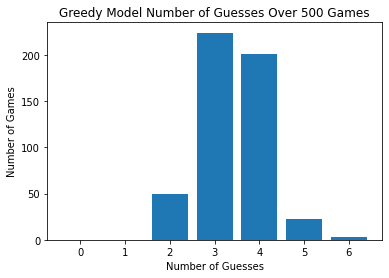

In [20]:
num_guesses = [zero_counts, one_counts, two_counts, three_counts, four_counts, five_counts, six_counts]
plt.bar(list(range(max_guesses+1)), num_guesses)
plt.xlabel("Number of Guesses")
plt.ylabel("Number of Games")
#Adjust title based on which model is used
plt.title("Greedy Model Number of Guesses Over 500 Games")
plt.show()